<span style="color:red; font-size:30px;"> The aim of this short code is to demonstrate that in the limit of very large size of a neural network the output distribution of data is Gaussian.</span>

We use a very simple forward NN with a single hidden layer.

If we use as input gaussian distributions with Mu=0 and STD=1 and we define the STD of the output layer as STD/hidden_size, then the minimum number of necessary neurons to have a final gaussian distribution is 3 (hidden_size = 3).

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import normaltest
from scipy.stats import norm
from scipy.optimize import curve_fit
import math

2023-05-30 15:06:54.927263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


=======================================================================================


<span style="color:blue; font-size:30px;"> Functions Definition </span>


$\bullet$ <span style="color:black; font-size:15px;"> $\textit{inizialization}$ </span> : it builds the initialization of the weights and the biases of the NN. The inputs for the function are the size of the input of the NN, the size of the hidden layer, i.e. the number of neurons (we are considering that all the hidden layers have the same number of neurons), the mean and the sigma of the Gaussian distribution from which we extract the values and finally the number of layers;

$\bullet$ <span style="color:black; font-size:15px;"> $\textit{forward}$ </span> : it defines the architecture of the NN and it computes the gradients of the output of the NN with respect the parameters of the weights and the biases;

$\bullet$ <span style="color:black; font-size:15px;"> $\textit{bootobj_extr}$ </span> : it extracts from the list a one parameter to plot the input histogram on the bootstrap events;


$\bullet$ <span style="color:black; font-size:15px;"> $\textit{data_law}$ </span> : it defines the law that we want to reconstruct;


$\bullet$ <span style="color:black; font-size:15px;"> $\textit{mean}$ </span> : it performs the bootstrap mean;


$\bullet$ <span style="color:black; font-size:15px;"> $\textit{std_dev}$ </span> : it performs the bootstrap std.


=======================================================================================

In [156]:
# Initialization of weights and bias with a normal distribution
def initialization(input_size_, hidden_size_, Mu_, STD_, nl):
    bname = 'b{}'.format(nl)
    Wname = 'W{}'.format(nl)
    WR = tf.Variable(tf.random.normal([input_size_, hidden_size_], mean=Mu_, stddev=STD_), name=Wname)
    BR = tf.Variable(tf.random.normal([hidden_size_], mean=Mu_, stddev=STD_), name=bname)
    return WR,BR

# Define the forward function to compute the output of the neural network
def forward(X, i, activation, depth_):
    with tf.GradientTape() as tape:
        tape.watch([param for param in [Ws[i, j] for j in range(depth_)] + [Bs[i, j] for j in range(depth_)]])
        
        A = X
        for j in range(depth_):
            Z = tf.add(tf.matmul(A, Ws[i, j]), Bs[i, j])
            A = activation(Z)
            
        Z_last = Z
    
    gradients = tape.gradient(Z_last, [Ws[i, j] for j in range(depth_)] + [Bs[i, j] for j in range(depth_)])
    return Z_last, gradients


def bootobj_extr(layer_, el1_, el2_):
    A = np.zeros(Nboot)
    B = np.zeros(Nboot)
    for i in range(Nboot):
        matrW = Ws[i, layer_]
        A[i] = matrW[el1_, el2_]
        vecB = Bs[i,layer_]
        B[i] = vecB[el1_]
    return A,B

#Chosen law for the test of the NN
def data_law(x_):
    return math.sin(x_)

#Bootstrap Mean and Sigma
def mean(arr):
    return sum(arr)/len(arr)
def std_dev(arr):
    arr_mean = mean(arr)
    return (sum([(i - arr_mean)**2 for i in arr]) / (len(arr)-1))**0.5

=======================================================================================


<span style="color:blue; font-size:30px;"> NN output computation </span>

In this part of the code we define the dimension of the NN and the input parameters.Then, given a training input and a test input we compute the output of the NN at the initialization. We also extract the gradient in both cases. These gradients are necessary to compute the $\Theta$s later in the code.


=======================================================================================

In [189]:
# Define the dimensions of the NN
input_size = 1
hidden_size = 3
output_size = 1
depth = 4
Nboot = 1000
lsizes = np.concatenate(([input_size], np.repeat(hidden_size, depth-1), [output_size]))
print(lsizes)


#Define parameters of the Gaussian distribution
STD = 0.08
Mu = 0.5


#Weights and biases generation
Ws = np.empty((Nboot, depth), dtype=object)  
Bs = np.empty((Nboot, depth), dtype=object)
for i in range(Nboot):
    for l in range(depth):
        Ws[i, l], Bs[i, l] = initialization(lsizes[l], lsizes[l+1], Mu, STD / lsizes[l], l)
    

# Input quantities
X = tf.constant([[30]], dtype=tf.float32) # training
xtest = tf.constant([[50]], dtype=tf.float32) # test
    

# We compute the output for each event for an input
output_array = []
output_array_test = []
grads_array = np.array([])
grads_array_test = np.array([])
for i in range (0, Nboot):
        
    Y, Grad = forward(X,i,tf.nn.relu, depth)
    Y_test, Grad_test = forward(xtest,i,tf.nn.relu, depth)
    output_array.append(Y.numpy()[0][0])
    output_array_test.append(Y_test.numpy()[0][0])
    
    # Flattening e concatenation of derivatives for training and test
    grads_np = np.concatenate([g.numpy().flatten() for g in Grad])  
    grads_test_np = np.concatenate([g.numpy().flatten() for g in Grad_test])  
    grads_array = np.vstack([grads_array, grads_np]) if grads_array.size else grads_np
    grads_array_test = np.vstack([grads_array_test, grads_test_np]) if grads_array_test.size else grads_test_np 
    
print(grads_array.shape, grads_array_test.shape)

[1 3 3 3 1]
(1000, 34) (1000, 34)


=======================================================================================


<span style="color:blue; font-size:30px;"> Input distributions histograms</span>


We check the input distribution of weights and biases.

=======================================================================================


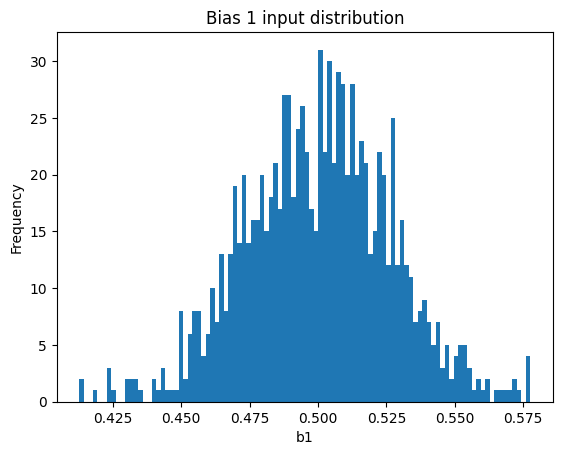

Data follow a gaussian distribution.


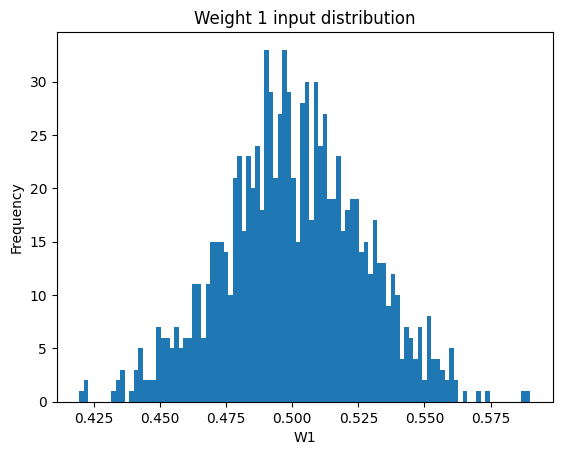

<Figure size 640x480 with 0 Axes>

In [190]:
Whist, Bhist = bootobj_extr(1,1,1)


# Print the input distributions of the weights and bias
plt.hist(Bhist, bins=100)
plt.xlabel('b1')
plt.ylabel('Frequency')
plt.title('Bias 1 input distribution')
plt.savefig('Bias1.png')
plt.show()

# Test of the gaussianity
stat, p = normaltest(Bhist)

# Print the result of the test
if p < 0.05:
    print("Data don't follow a gaussian distribution.")
else:
    print("Data follow a gaussian distribution.")

plt.clf()


plt.hist(Whist, bins=100)
plt.xlabel('W1')
plt.ylabel('Frequency')
plt.title('Weight 1 input distribution')
plt.show()

plt.clf()

=======================================================================================


<span style="color:blue; font-size:30px;"> Output distribution histogram</span>


We study the output distribution.


=======================================================================================

No gaussian distribution.


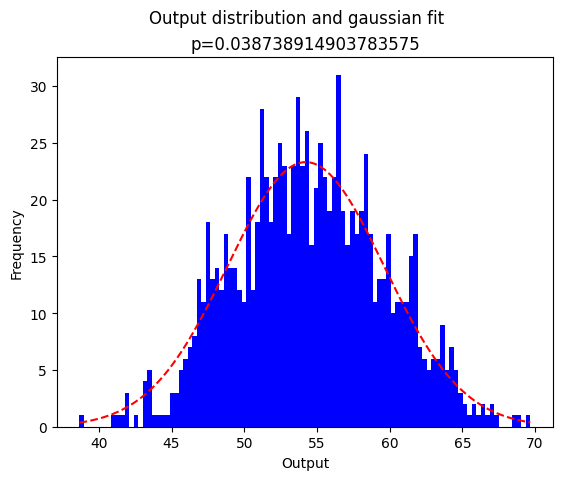

Mean: 54.233009659571216
Standard deviation: -5.3886513145318595
Amplitude: 23.304942406319796


In [191]:
# Test of the gaussianity
stat, p = normaltest(output_array)

# Print the result of the test
if p < 0.05:
    string = "No gaussian distribution." 
    print(string)
else:
    string = "Gaussian distribution."
    print(string)

# Take parameters of our histogram
counts, bins, _ = plt.hist(output_array, bins=100)

ylim = max(counts)-10
xlim = min(bins)
xlim2 = max(bins)

# Define the Gaussian function
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))


# Plot the histogram and the fitted Gaussian function
plt.clf()
x = np.linspace(xlim, xlim2, 1000)
plt.hist(output_array, bins=100, color ='blue')
plt.xlabel('Output')
plt.ylabel('Frequency')
plt.suptitle('Output distribution and gaussian fit')
plt.title('p='+ str(p))
p0 = [(xlim+xlim2)/2, xlim2-xlim, 1]
coeff, var_matrix = curve_fit(gaussian, bins[:-1], counts, p0=p0)
plt.plot(x, gaussian(x, *coeff), 'r--', label='fit')    
    
#plt.text(xlim-3, ylim, 'L='+ str(hidden_size), fontsize=18)
#plt.text(xlim-3, ylim, string, fontsize=8)
plt.savefig('Output.png')
plt.show()

# Print gaussian parameters
print("Mean:", coeff[0])
print("Standard deviation:", coeff[1])
print("Amplitude:", coeff[2])

=======================================================================================

<span style="color:blue; font-size:30px;"> Computation of the theta quantities </span>

$\hat{\Theta}_0(x,\mathcal{X}) = \theta = \sum_{l=1}^{L+1}\nabla_{\theta^\ell}f_t(\mathcal{X})\nabla_{\theta^\ell}f_t(\mathcal{X})^T \\$ 
$\hat{\Theta}(X,X) = \theta_{test} = \sum_{l=1}^{L+1}\nabla_{\theta^\ell}f_t($x$)\nabla_{\theta^\ell}f_t(\mathcal{X})^T$ 

where $x$ is the test input value while \mathcal{X} is the training input value.

=======================================================================================

In [192]:
#Theta computation
theta = np.zeros(Nboot)
for iboot in range(Nboot):
    theta[iboot] = sum(grads_array[iboot,i]**2 for i in range(int(grads_array[0,:].shape[0])))

#Theta test computation
theta_test = np.zeros(Nboot)
for iboot in range(Nboot):
    theta_test[iboot] = sum(grads_array_test[iboot,i]*grads_array[iboot,i] for i in range(int(grads_array[0,:].shape[0])))

=======================================================================================

<span style="color:blue; font-size:30px;"> Definition of the ODE solutions for the training and the test </span>

TRAINING:

$\omega_t = -\nabla_\theta f_0(\mathcal{X})^T\hat{\Theta}_0^{-1}\bigg(\mathbb{I}-e^{-\eta \hat{\Theta}_0 t}\bigg)\big(f_0(\mathcal{X})-\mathcal(Y)\big),\\$
$f_t^{lin}(\mathcal{X}) = \bigg(\mathbb{I} - e^{-\eta \hat{\Theta}_0 t}\bigg)\mathcal{Y}+e^{-\eta \hat{\Theta}_0 t} f_0(\mathcal{X}).$

TEST:

$f_t^{lin}(x) = \mu_t(x) + \gamma_t(x)$

where

$\mu_t(x) = \hat{\Theta}_0(x,\mathcal{X}) \hat{\Theta}_0^{-1} \bigg(\mathbb{I}-e^{-\eta \hat{\Theta}_0 t}\bigg) \mathcal{Y},\\$
$\gamma_t(x) = f_0(x) - \hat{\Theta}_0(x,\mathcal{X}) \hat{\Theta}_0^{-1} \bigg(\mathbb{I}-e^{-\eta \hat{\Theta}_0 t}\bigg) f_0(\mathcal{X})$


=======================================================================================

In [193]:
def Train(grad_, theta_, eta_, t_, output_, Y_):
    omega_t = -grad_/theta_*(1-math.exp(-eta_*theta_*t_))*(output_ - Y_)
    f_lin = (1-math.exp(-eta_*theta_*t_))*Y_ + math.exp(-eta_*theta_*t_)*output_
    return omega_t, f_lin

def Ver(theta_, theta_test_, eta_, t_, Y_, output_test_, output_):
    mu_t = theta_test_*theta_**(-1)*(1-math.exp(-eta_*theta_*t_))*Y_
    gamma_t = output_test_ - theta_*theta_**(-1)*(1-math.exp(-theta_*eta_*t_))*output_
    flin_f = mu_t + gamma_t
    return flin_f
print(len(output_array), len(output_array_test))

1000 1000


=======================================================================================

<span style="color:blue; font-size:30px;"> Computation of the training functions as a function of time $t$ for different bins </span>

We expect that in the limit of large values of time the function tends to the value $\mathcal{Y}$

=======================================================================================

-0.9880316240928618 (1000, 34)


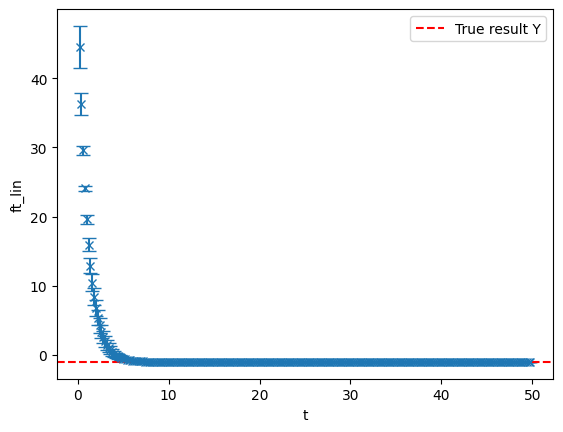

In [194]:
# True value for our chosen law
Y = data_law(X)
print(Y, grads_array.shape)

# Bins of t
Bins = np.arange(0,50,0.2)


# Computation of flin for the training
flin_tr = np.empty((Nboot, len(Bins)))
for i in range(Nboot):
    for j in range(len(Bins)):
        _, flin_tr_app = Train(grads_array[i,:],theta[i], 0.0001, Bins[j], output_array[i], Y)
        flin_tr[i,j] = flin_tr_app


# Bootstrap mean and sigma
flin_tr_mu = np.empty(len(Bins))
flin_tr_s = np.empty(len(Bins))
for i in range(len(Bins)):
    flin_tr_mu[i] = mean(flin_tr[:,i])
    flin_tr_s[i] = std_dev(flin_tr[:,i])
    
#print(flin_tr_mu)


# Plot of the shape as a function of t
plt.errorbar(Bins[1:], flin_tr_mu[1:], yerr=flin_tr_s[1:], fmt='x', capsize=5)
plt.axhline(Y, color='r', linestyle='--', label='True result Y')
plt.legend()
plt.xlabel('t')
plt.ylabel('ft_lin')
plt.show()

=======================================================================================

<span style="color:blue; font-size:30px;"> Computation of the test functions as a function of time $t$ for different bins </span>


=======================================================================================

1.6416756883041732 14552.520254686475 8864.43062924262


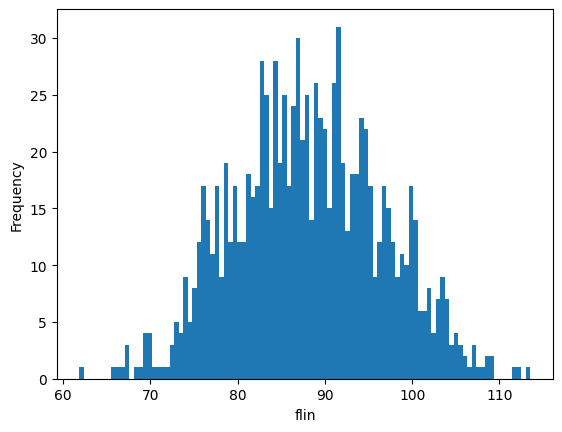

-0.9880316240928618 50.505814


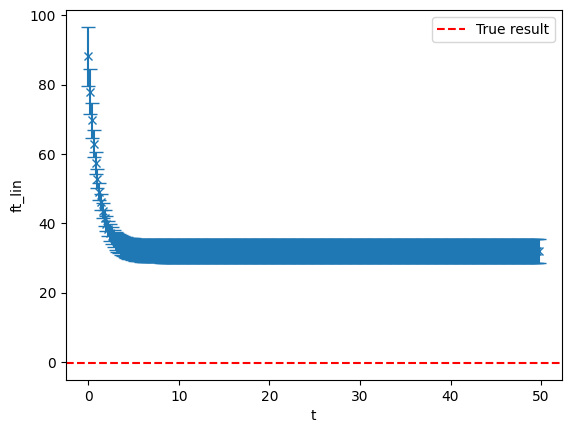

In [195]:
flin = np.empty((Nboot, len(Bins)))
for i in range(Nboot):
    for j in range(len(Bins)):
        flin_app = Ver(theta[i], theta_test[i], 0.0001, Bins[j], Y, output_array_test[i], output_array[i])
        flin[i,j] = flin_app

print(theta_test[0]/theta[0], theta_test[0], theta[0])
        
plt.hist(flin[:,0], bins=100)
plt.xlabel('flin')
plt.ylabel('Frequency')
plt.title('')
plt.show()

print(Y, output_array[0])

flin_mu = np.empty(len(Bins))
flin_s = np.empty(len(Bins))
for i in range(len(Bins)):
    flin_mu[i] = mean(flin[:,i])
    flin_s[i] = std_dev(flin[:,i])

Y2 = data_law(xtest)

plt.errorbar(Bins, flin_mu, yerr=flin_s, fmt='x', capsize=5)
plt.axhline(Y2, color='r', linestyle='--', label='True result')
plt.legend()
plt.xlabel('t')
plt.ylabel('ft_lin')
plt.show()